In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
#dataset loading
df = pd.read_csv("C:/Users/avish/Desktop/Sem 8/Final Project/Heart_Disease_Prediction/CVD/data/heart.csv")

In [7]:
# Rename columns (from your previous code)
df = df.rename(
    columns={
        'cp': 'chest_pain_type',
        'trestbps': 'resting_blood_pressure',
        'chol': 'cholesterol',
        'fbs': 'fasting_blood_sugar',
        'restecg': 'resting_electrocardiogram',
        'thalach': 'max_heart_rate_achieved',
        'exang': 'exercise_induced_angina',
        'oldpeak': 'st_depression',
        'slope': 'st_slope',
        'ca': 'num_major_vessels',
        'thal': 'thalassemia'
    }
)

In [8]:
# dropping the wrong ca vlaues and error values from thal
df = df[df['num_major_vessels']<4]
df = df[df['thalassemia']>0]
print(f'The length of the data row now is {len(df)} instead of 1025')

The length of the data row now is 1000 instead of 1025


In [9]:
# Define features and target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Check class distribution before SMOTE
print("Class distribution before SMOTE:", pd.Series(y).value_counts().to_dict())

Class distribution before SMOTE: {1: 508, 0: 492}


In [10]:
# Apply SMOTE to balance classes
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:", pd.Series(y).value_counts().to_dict())

Class distribution after SMOTE: {0: 508, 1: 508}


In [11]:
# Split into train (80%), validation (10%), test (10%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1111, random_state=42)

In [12]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [13]:
import pickle
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [9]:
# Reshape for deep learning (CNN and Transformer expect 3D input: samples, features, 1)
X_train_dl = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_dl = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_dl = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Print shapes
print("X_train shape:", X_train.shape, "X_train_dl shape:", X_train_dl.shape)
print("X_val shape:", X_val.shape, "X_val_dl shape:", X_val_dl.shape)
print("X_test shape:", X_test.shape, "X_test_dl shape:", X_test_dl.shape)
print("y_train shape:", y_train.shape, "y_val shape:", y_val.shape, "y_test shape:", y_test.shape)

X_train shape: (812, 13) X_train_dl shape: (812, 13, 1)
X_val shape: (102, 13) X_val_dl shape: (102, 13, 1)
X_test shape: (102, 13) X_test_dl shape: (102, 13, 1)
y_train shape: (812,) y_val shape: (102,) y_test shape: (102,)


In [11]:
# Define CNN model
cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=(13, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
# Train model
cnn_history = cnn_model.fit(
    X_train_dl, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_dl, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5651 - loss: 0.6718 - val_accuracy: 0.7451 - val_loss: 0.5858
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7735 - loss: 0.5495 - val_accuracy: 0.7451 - val_loss: 0.5059
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8085 - loss: 0.4432 - val_accuracy: 0.8137 - val_loss: 0.4536
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8204 - loss: 0.3831 - val_accuracy: 0.8431 - val_loss: 0.4435
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8557 - loss: 0.3561 - val_accuracy: 0.8333 - val_loss: 0.4431
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8614 - loss: 0.3307 - val_accuracy: 0.8333 - val_loss: 0.4153
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8688 - loss: 0.3245 - val_accuracy: 0.8431 - val_loss: 0.4105
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8551 - loss: 0.3880 - val_accuracy: 0.8235 - val_loss

In [13]:
# Evaluate on test set
cnn_test_pred_proba = cnn_model.predict(X_test_dl).flatten()
cnn_test_pred = (cnn_test_pred_proba > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [14]:
# Metrics
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test_dl, y_test, verbose=0)
cnn_test_pred_proba = cnn_model.predict(X_test_dl).flatten()
cnn_test_pred = (cnn_test_pred_proba > 0.5).astype(int)
cnn_accuracy = accuracy_score(y_test, cnn_test_pred)
cnn_report = classification_report(y_test, cnn_test_pred, output_dict=True)
cnn_cm = confusion_matrix(y_test, cnn_test_pred)
cnn_fpr, cnn_tpr, _ = roc_curve(y_test, cnn_test_pred_proba)
cnn_roc_auc = auc(cnn_fpr, cnn_tpr)

print("CNN Test Performance Metrics:")
print(f"Test Loss: {cnn_test_loss:.4f}")
print(f"Test Accuracy: {cnn_test_accuracy*100:.2f}%")
print(f"Accuracy (sklearn): {cnn_accuracy*100:.2f}%")
print(f"ROC-AUC: {cnn_roc_auc:.2f}")
print(f"Recall: {cnn_report['1']['recall']:.2f}")
print(f"Precision: {cnn_report['1']['precision']:.2f}")
print(f"F1-Score: {cnn_report['1']['f1-score']:.2f}")
print("Confusion Matrix:\n", cnn_cm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
CNN Test Performance Metrics:
Test Loss: 0.1165
Test Accuracy: 96.08%
Accuracy (sklearn): 96.08%
ROC-AUC: 0.99
Recall: 0.93
Precision: 1.00
F1-Score: 0.97
Confusion Matrix:
 [[41  0]
 [ 4 57]]


In [15]:
# Check for underfitting/overfitting
train_loss_final = cnn_history.history['loss'][-1]
val_loss_final = cnn_history.history['val_loss'][-1]
train_acc_final = cnn_history.history['accuracy'][-1]
val_acc_final = cnn_history.history['val_accuracy'][-1]

print("\nCNN Underfitting/Overfitting Analysis:")
print(f"Final Training Loss: {train_loss_final:.4f}, Validation Loss: {val_loss_final:.4f}")
print(f"Final Training Accuracy: {train_acc_final*100:.2f}%, Validation Accuracy: {val_acc_final*100:.2f}%")
if train_loss_final > val_loss_final + 0.1 or train_acc_final < 0.7:
    print("Possible Underfitting: Training loss is high or accuracy is low.")
elif val_loss_final > train_loss_final + 0.1 and val_acc_final < train_acc_final - 0.1:
    print("Possible Overfitting: Validation loss/accuracy significantly worse than training.")
else:
    print("Good Fit: Training and validation metrics are close.")


CNN Underfitting/Overfitting Analysis:
Final Training Loss: 0.0851, Validation Loss: 0.1579
Final Training Accuracy: 96.92%, Validation Accuracy: 94.12%
Good Fit: Training and validation metrics are close.


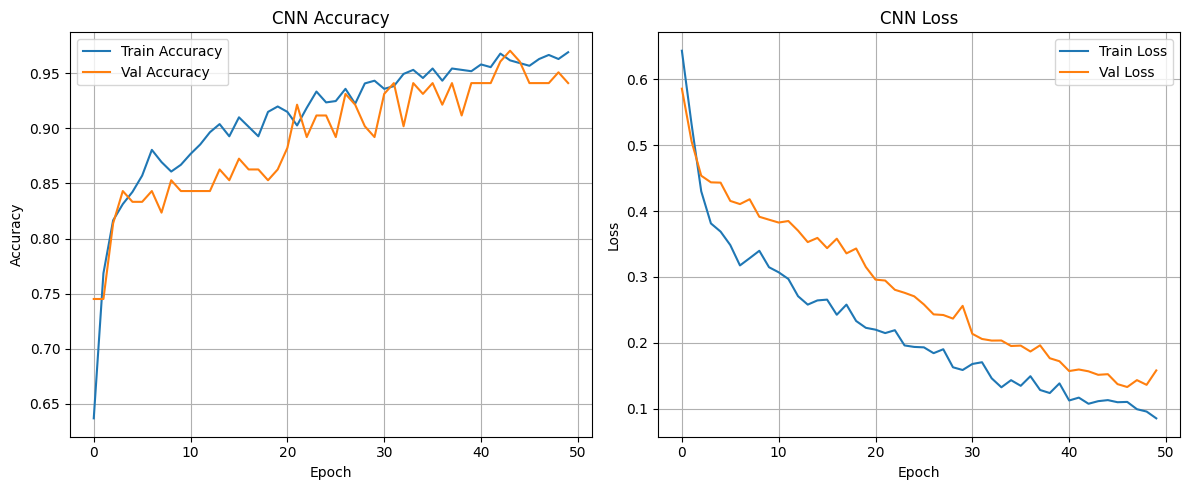

In [16]:
# Plot accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(cnn_history.history['accuracy'], label='Train Accuracy')
ax1.plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('CNN Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(cnn_history.history['loss'], label='Train Loss')
ax2.plot(cnn_history.history['val_loss'], label='Val Loss')
ax2.set_title('CNN Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# save cnn model
cnn_model.save("models/computer_cnn_model.keras")
print("Model saved!")

Transformer Model

In [ ]:
# # Transformer Model
# class MultiHeadSelfAttention(tf.keras.layers.Layer):
#     def __init__(self, embed_dim, num_heads):
#         super(MultiHeadSelfAttention, self).__init__()
#         self.embed_dim = embed_dim
#         self.num_heads = num_heads
#         assert embed_dim % num_heads == 0
#         self.projection_dim = embed_dim // num_heads
#         self.query_dense = Dense(embed_dim)
#         self.key_dense = Dense(embed_dim)
#         self.value_dense = Dense(embed_dim)
#         self.combine_heads = Dense(embed_dim)

#     def attention(self, query, key, value):
#         score = tf.matmul(query, key, transpose_b=True)
#         dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
#         scaled_score = score / tf.math.sqrt(dim_key)
#         weights = tf.nn.softmax(scaled_score, axis=-1)
#         output = tf.matmul(weights, value)
#         return output, weights

#     def separate_heads(self, x, batch_size):
#         x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
#         return tf.transpose(x, perm=[0, 2, 1, 3])

#     def call(self, inputs, training=None):
#         batch_size = tf.shape(inputs)[0]
#         query = self.query_dense(inputs)
#         key = self.key_dense(inputs)
#         value = self.value_dense(inputs)
#         query = self.separate_heads(query, batch_size)
#         key = self.separate_heads(key, batch_size)
#         value = self.separate_heads(value, batch_size)
#         attention, weights = self.attention(query, key, value)
#         attention = tf.transpose(attention, perm=[0, 2, 1, 3])
#         concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
#         output = self.combine_heads(concat_attention)
#         return output

# class TransformerBlock(tf.keras.layers.Layer):
#     def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
#         super(TransformerBlock, self).__init__()
#         self.att = MultiHeadSelfAttention(embed_dim, num_heads)
#         self.ffn = Sequential([Dense(ff_dim, activation='relu'), Dense(embed_dim)])
#         self.layernorm1 = LayerNormalization(epsilon=1e-6)
#         self.layernorm2 = LayerNormalization(epsilon=1e-6)
#         self.dropout1 = Dropout(rate)
#         self.dropout2 = Dropout(rate)

#     def call(self, inputs, training=None):
#         attn_output = self.att(inputs, training=training)
#         attn_output = self.dropout1(attn_output, training=training)
#         out1 = self.layernorm1(inputs + attn_output)
#         ffn_output = self.ffn(out1)
#         ffn_output = self.dropout2(ffn_output, training=training)
#         return self.layernorm2(out1 + ffn_output)

# def build_transformer(input_shape, embed_dim=64, num_heads=4, ff_dim=128):
#     inputs = Input(shape=(input_shape, 1))
#     x = Dense(embed_dim)(inputs)
#     x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
#     x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
#     x = tf.keras.layers.GlobalAveragePooling1D()(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(0.2)(x)
#     outputs = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
#                   loss='binary_crossentropy', 
#                   metrics=['accuracy'])
#     return model

In [ ]:
# # Instantiate and train the model
# transformer_model = build_transformer(13)
# transformer_history = transformer_model.fit(
#     X_train_dl, y_train,
#     epochs=100,
#     batch_size=32,
#     validation_data=(X_val_dl, y_val),
#     callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
#     verbose=1
# )

In [ ]:
# transformer_test_loss, transformer_test_accuracy = transformer_model.evaluate(X_test_dl, y_test, verbose=0)
# transformer_test_pred_proba = transformer_model.predict(X_test_dl).flatten()
# threshold = 0.3
# transformer_test_pred = (transformer_test_pred_proba > threshold).astype(int)
# print("Transformer Test Performance Metrics (Threshold=0.3):")

# transformer_accuracy = accuracy_score(y_test, transformer_test_pred)
# transformer_report = classification_report(y_test, transformer_test_pred, output_dict=True)
# transformer_cm = confusion_matrix(y_test, transformer_test_pred)
# transformer_fpr, transformer_tpr, _ = roc_curve(y_test, transformer_test_pred_proba)
# transformer_roc_auc = auc(transformer_fpr, transformer_tpr)
# print(f"Test Loss: {transformer_test_loss:.4f}")
# print(f"Test Accuracy: {transformer_test_accuracy*100:.2f}%")
# print(f"Accuracy (sklearn, threshold=0.3): {transformer_accuracy*100:.2f}%")
# print(f"ROC-AUC: {transformer_roc_auc:.2f}")
# print(f"Recall: {transformer_report['1']['recall']:.2f}")
# print(f"Precision: {transformer_report['1']['precision']:.2f}")
# print(f"F1-Score: {transformer_report['1']['f1-score']:.2f}")
# print("Confusion Matrix:\n", transformer_cm)

In [ ]:
# # Check for underfitting/overfitting
# train_loss_final = transformer_history.history['loss'][-1]
# val_loss_final = transformer_history.history['val_loss'][-1]
# train_acc_final = transformer_history.history['accuracy'][-1]
# val_acc_final = transformer_history.history['val_accuracy'][-1]

# print("\nTransformer Underfitting/Overfitting Analysis:")
# print(f"Final Training Loss: {train_loss_final:.4f}, Validation Loss: {val_loss_final:.4f}")
# print(f"Final Training Accuracy: {train_acc_final*100:.2f}%, Validation Accuracy: {val_acc_final*100:.2f}%")
# if train_loss_final > val_loss_final + 0.1 or train_acc_final < 0.7:
#     print("Possible Underfitting: Training loss is high or accuracy is low.")
# elif val_loss_final > train_loss_final + 0.1 and val_acc_final < train_acc_final - 0.1:
#     print("Possible Overfitting: Validation loss/accuracy significantly worse than training.")
# else:
#     print("Good Fit: Training and validation metrics are close.")

In [ ]:
# # Plot accuracy and loss
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# ax1.plot(transformer_history.history['accuracy'], label='Train Accuracy')
# ax1.plot(transformer_history.history['val_accuracy'], label='Val Accuracy')
# ax1.set_title('Transformer Accuracy')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Accuracy')
# ax1.legend()
# ax1.grid(True)

# ax2.plot(transformer_history.history['loss'], label='Train Loss')
# ax2.plot(transformer_history.history['val_loss'], label='Val Loss')
# ax2.set_title('Transformer Loss')
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Loss')
# ax2.legend()
# ax2.grid(True)
# plt.tight_layout()
# plt.show()

GELU 

In [18]:
# Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.embed_dim = embed_dim
        self.pos_encoding = self.positional_encoding(max_len, embed_dim)

    def positional_encoding(self, max_len, embed_dim):
        pos = np.arange(max_len)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle_rads = pos / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Multi-Head Self-Attention Layer
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training=None):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

# Transformer Block with GELU
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='gelu'),  # Changed to GELU
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build Transformer Model
def build_transformer(input_shape, embed_dim=128, num_heads=8, ff_dim=256):
    inputs = Input(shape=(input_shape, 1))
    x = Dense(embed_dim)(inputs)
    x = PositionalEncoding(max_len=input_shape, embed_dim=embed_dim)(x)  # Add Positional Encoding
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dense(128, activation='gelu')(x)  # Changed to GELU
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [19]:
# Instantiate and train the model
transformer_model = build_transformer(13)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
transformer_history = transformer_model.fit(
    X_train_dl, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_dl, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5840 - loss: 0.6926 - val_accuracy: 0.6176 - val_loss: 0.6562
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5766 - loss: 0.6741 - val_accuracy: 0.6863 - val_loss: 0.6158
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6718 - loss: 0.6214 - val_accuracy: 0.6667 - val_loss: 0.5820
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6448 - loss: 0.6341 - val_accuracy: 0.7549 - val_loss: 0.5467
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7338 - loss: 0.5615 - val_accuracy: 0.7647 - val_loss: 0.5389
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7396 - loss: 0.5734 - val_accuracy: 0.7745 - val_loss: 0.5181
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7567 - loss: 0.5273 - val_accuracy: 0.7745 - val_loss: 0.5068
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7974 - loss: 0.4856 - val_accuracy: 0

In [20]:
# Evaluate on test set
transformer_test_loss, transformer_test_accuracy = transformer_model.evaluate(X_test_dl, y_test, verbose=0)
transformer_test_pred_proba = transformer_model.predict(X_test_dl).flatten()
transformer_test_pred = (transformer_test_pred_proba > 0.3).astype(int)

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
transformer_accuracy = accuracy_score(y_test, transformer_test_pred)
transformer_report = classification_report(y_test, transformer_test_pred, output_dict=True)
transformer_cm = confusion_matrix(y_test, transformer_test_pred)
transformer_fpr, transformer_tpr, _ = roc_curve(y_test, transformer_test_pred_proba)
transformer_roc_auc = auc(transformer_fpr, transformer_tpr)

print("Transformer Test Performance Metrics (Threshold=0.3):")
print(f"Test Loss: {transformer_test_loss:.4f}")
print(f"Test Accuracy: {transformer_test_accuracy*100:.2f}%")
print(f"Accuracy (sklearn, threshold=0.3): {transformer_accuracy*100:.2f}%")
print(f"ROC-AUC: {transformer_roc_auc:.2f}")
print(f"Recall: {transformer_report['1']['recall']:.2f}")
print(f"Precision: {transformer_report['1']['precision']:.2f}")
print(f"F1-Score: {transformer_report['1']['f1-score']:.2f}")
print("Confusion Matrix:\n", transformer_cm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Transformer Test Performance Metrics (Threshold=0.3):
Test Loss: 0.1309
Test Accuracy: 98.04%
Accuracy (sklearn, threshold=0.3): 98.04%
ROC-AUC: 0.99
Recall: 0.98
Precision: 0.98
F1-Score: 0.98
Confusion Matrix:
 [[40  1]
 [ 1 60]]


In [21]:
# Check for underfitting/overfitting
train_loss_final = transformer_history.history['loss'][-1]
val_loss_final = transformer_history.history['val_loss'][-1]
train_acc_final = transformer_history.history['accuracy'][-1]
val_acc_final = transformer_history.history['val_accuracy'][-1]

print("\nTransformer Underfitting/Overfitting Analysis:")
print(f"Final Training Loss: {train_loss_final:.4f}, Validation Loss: {val_loss_final:.4f}")
print(f"Final Training Accuracy: {train_acc_final*100:.2f}%, Validation Accuracy: {val_acc_final*100:.2f}%")
if train_loss_final > val_loss_final + 0.1 or train_acc_final < 0.7:
    print("Possible Underfitting: Training loss is high or accuracy is low.")
elif val_loss_final > train_loss_final + 0.1 and val_acc_final < train_acc_final - 0.1:
    print("Possible Overfitting: Validation loss/accuracy significantly worse than training.")
else:
    print("Good Fit: Training and validation metrics are close.")


Transformer Underfitting/Overfitting Analysis:
Final Training Loss: 0.0659, Validation Loss: 0.1626
Final Training Accuracy: 97.91%, Validation Accuracy: 95.10%
Good Fit: Training and validation metrics are close.


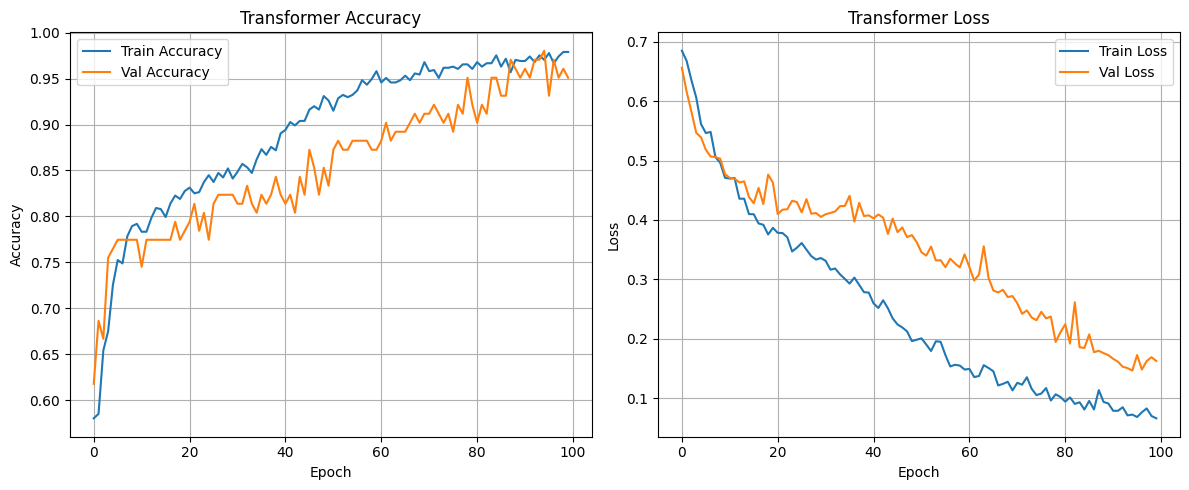

In [22]:
# Plot accuracy and loss
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(transformer_history.history['accuracy'], label='Train Accuracy')
ax1.plot(transformer_history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Transformer Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(transformer_history.history['loss'], label='Train Loss')
ax2.plot(transformer_history.history['val_loss'], label='Val Loss')
ax2.set_title('Transformer Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# save transformer model
cnn_model.save("models/computer_transformer_model.keras")
print("Model saved!")

Model saved!


CNN Hyperparameter Tuning

In [ ]:
# # Done in kaggle and downloaded 
# import keras_tuner as kt
# def build_cnn_tuner(hp):
#     model = Sequential([
#         Conv1D(
#             filters=hp.Int('filters1', 16, 64, step=16),
#             kernel_size=3,
#             activation='relu',
#             padding='same',
#             input_shape=(13, 1)
#         ),
#         MaxPooling1D(pool_size=2),
#         Conv1D(
#             filters=hp.Int('filters2', 32, 128, step=32),
#             kernel_size=3,
#             activation='relu',
#             padding='same'
#         ),
#         MaxPooling1D(pool_size=2),
#         Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)),
#         Flatten(),
#         Dense(hp.Int('dense_units', 32, 128, step=32), activation='relu'),
#         Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1)),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# tuner = kt.Hyperband(
#     build_cnn_tuner,
#     objective='val_accuracy',
#     max_epochs=50,
#     factor=3,
#     directory='cnn_tuner',
#     project_name='heart_disease'
# )
# tuner.search(
#     X_train_dl, y_train,
#     epochs=50,
#     validation_data=(X_val_dl, y_val),
#     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
# )
# best_cnn_model = tuner.get_best_models(num_models=1)[0]

# # Evaluate best CNN model
# best_cnn_test_loss, best_cnn_test_accuracy = best_cnn_model.evaluate(X_test_dl, y_test, verbose=0)
# print(f"Best CNN Test Accuracy: {best_cnn_test_accuracy*100:.2f}%")

Transformer Hyperparameter Tuning

In [1]:
# Done in kaggle and downloaded 
# def build_transformer_tuner(hp):
#     embed_dim = hp.Int('embed_dim', 32, 128, step=32)
#     num_heads = hp.Int('num_heads', 2, 8, step=2)
#     ff_dim = hp.Int('ff_dim', 64, 256, step=64)
#     learning_rate = hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')
    
#     inputs = Input(shape=(13, 1))
#     x = Dense(embed_dim)(inputs)
#     x = PositionalEncoding(max_len=13, embed_dim=embed_dim)(x)
#     x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
#     x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
#     x = tf.keras.layers.GlobalAveragePooling1D()(x)
#     x = Dense(128, activation='gelu')(x)
#     x = Dropout(0.3)(x)
#     outputs = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# tuner = kt.Hyperband(
#     build_transformer_tuner,
#     objective='val_accuracy',
#     max_epochs=50,
#     factor=3,
#     directory='transformer_tuner',
#     project_name='heart_disease'
# )
# tuner.search(
#     X_train_dl, y_train,
#     epochs=50,
#     validation_data=(X_val_dl, y_val),
#     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
# )
# best_transformer_model = tuner.get_best_models(num_models=1)[0]

# # Evaluate best Transformer model
# best_transformer_test_loss, best_transformer_test_accuracy = best_transformer_model.evaluate(X_test_dl, y_test, verbose=0)
# print(f"Best Transformer Test Accuracy: {best_transformer_test_accuracy*100:.2f}%")

In [2]:
# from sklearn.model_selection import KFold
# # Updated build_transformer_tuner function
# def build_transformer_tuner(hp):
#     # Define embed_dim
#     embed_dim = hp.Int('embed_dim', 32, 256, step=32)
#     # **Changed**: Dynamically select num_heads to ensure divisibility by embed_dim
#     max_heads = min(16, embed_dim)  # Cap at 16 or embed_dim
#     valid_heads = [h for h in range(2, max_heads + 1, 2) if embed_dim % h == 0]
#     num_heads = hp.Choice('num_heads', valid_heads) if valid_heads else 2  # Fallback to 2 if no valid heads
#     ff_dim = hp.Int('ff_dim', 64, 512, step=64)
#     dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
#     num_blocks = hp.Int('num_blocks', 2, 4, step=1)
#     learning_rate = hp.Choice('learning_rate', [1e-5, 5e-5, 1e-4, 5e-4, 1e-3])
#     weight_decay = hp.Float('weight_decay', 1e-6, 1e-2, sampling='log')
#     pooling = hp.Choice('pooling', ['avg', 'max'])

#     inputs = tf.keras.layers.Input(shape=(13, 1))
#     x = tf.keras.layers.Dense(embed_dim)(inputs)
#     x = PositionalEncoding(max_len=13, embed_dim=embed_dim)(x)
#     for _ in range(num_blocks):
#         x = TransformerBlock(embed_dim, num_heads, ff_dim, rate=dropout_rate)(x)
#     if pooling == 'avg':
#         x = tf.keras.layers.GlobalAveragePooling1D()(x)
#     else:
#         x = tf.keras.layers.GlobalMaxPooling1D()(x)
#     x = tf.keras.layers.Dense(128, activation='gelu')(x)
#     x = tf.keras.layers.Dropout(dropout_rate)(x)
#     outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# # Combine training and validation data for cross-validation
# X_full = np.concatenate([X_train_dl, X_val_dl], axis=0)
# y_full = np.concatenate([y_train, y_val], axis=0)

# # Create tuner
# tuner = kt.Hyperband(
#     build_transformer_tuner,
#     objective='val_accuracy',
#     max_epochs=50,
#     hyperband_iterations=3,
#     factor=3,
#     # **Changed**: Increased max_consecutive_failed_trials to tolerate potential failures
#     max_consecutive_failed_trials=10,
#     directory='transformer_tuner',
#     project_name='heart_disease_cv'
# )

# # Perform tuning with cross-validation
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# for fold, (train_idx, val_idx) in enumerate(kfold.split(X_full, y_full)):
#     X_train_fold = X_full[train_idx]
#     y_train_fold = y_full[train_idx]
#     X_val_fold = X_full[val_idx]
#     y_val_fold = y_full[val_idx]
#     tuner.search(
#         X_train_fold, y_train_fold,
#         epochs=50,
#         validation_data=(X_val_fold, y_val_fold),
#         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
#     )

# # Get the best model
# best_transformer_model = tuner.get_best_models(num_models=1)[0]

# # Evaluate on test set
# best_transformer_test_loss, best_transformer_test_accuracy = best_transformer_model.evaluate(X_test_dl, y_test, verbose=0)
# print(f"Best Transformer Test Accuracy: {best_transformer_test_accuracy*100:.2f}%")